# Class 1 - Bot

## Loading the data

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import (chi2, f_classif, mutual_info_classif, RFE, SelectFromModel, SelectKBest)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Define the list of file names
file_names = [
    "../../train/02-14-2018_clean.csv",
    "../../train/02-15-2018_clean.csv",
    "../../train/02-16-2018_clean.csv",
    "../../train/02-20-2018_clean.csv",
    "../../train/02-21-2018_clean.csv",
    "../../train/02-22-2018_clean.csv",
    "../../train/02-23-2018_clean.csv",
    "../../train/02-28-2018_clean.csv",
    "../../train/03-01-2018_clean.csv",
    "../../train/03-02-2018_clean.csv"
]

# Initialize an empty list to store the DataFrames
dfs = []

# Loop through the file names and read each file as a DataFrame
for file_name in file_names:
    df = pd.read_csv(file_name)
    dfs.append(df)

# Concatenate the DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

# Print the shape of the combined DataFrame
print(data.shape)

(12639793, 71)


In [3]:
# Assuming your DataFrame is named 'data'
instances_label_0 = data.query("Label == 0").sample(n=180558)
instances_label_1 = data.query("Label == 1").sample(n=180558)

# Combine the two DataFrames
combined_df = pd.concat([instances_label_0, instances_label_1])

In [4]:
test_instances_label_0 = data.query("Label == 0").drop(instances_label_0.index).sample(n=45139)
test_instances_label_1 = data.query("Label == 1").drop(instances_label_1.index).sample(n=45139)

# Combine the two DataFrames
test_combined_df = pd.concat([test_instances_label_0, test_instances_label_1])

In [5]:
X_train = combined_df.drop(columns='Label')
y_train = combined_df['Label']

X_test = test_combined_df.drop(columns='Label')
y_test = test_combined_df['Label']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Feature extraction

In [6]:
# 1. Information Gain (IG)
selector_ig = SelectKBest(score_func=mutual_info_classif, k=10)
X_train_ig = selector_ig.fit_transform(X_train, y_train)
X_test_ig = selector_ig.transform(X_test)
selected_columns_ig = X_train.columns[selector_ig.get_support()]

# 2. Chi-Square (CS)
selector_cs = SelectKBest(score_func=chi2, k=10)
X_train_cs = selector_cs.fit_transform(X_train_scaled, y_train)
X_test_cs = selector_cs.transform(X_test_scaled)
selected_columns_cs = X_train.columns[selector_cs.get_support()]

# 3. Gain Ratio (GR)
def gain_ratio(X, y):
    mi = mutual_info_classif(X, y)
    H_y = -np.sum(np.unique(y, return_counts=True)[1] / len(y) * np.log2(np.unique(y, return_counts=True)[1] / len(y)))
    return mi / H_y

selector_gr = SelectKBest(score_func=gain_ratio, k=10)
X_train_gr = selector_gr.fit_transform(X_train, y_train)
X_test_gr = selector_gr.transform(X_test)
selected_columns_gr = X_train.columns[selector_gr.get_support()]

# 4. Recursive Feature Elimination (RFE)
logreg = LogisticRegression()
selector_rfe = RFE(logreg, n_features_to_select=10)
X_train_rfe = selector_rfe.fit_transform(X_train, y_train)
X_test_rfe = selector_rfe.transform(X_test)
selected_columns_rfe = X_train.columns[selector_rfe.get_support()]

# 5. SelectKBest
selector_skb = SelectKBest(score_func=f_classif, k=10)
X_train_skb = selector_skb.fit_transform(X_train, y_train)
X_test_skb = selector_skb.transform(X_test)
selected_columns_skb = X_train.columns[selector_skb.get_support()]

# 6. Feature Importance using Tree-based Models
rfc = RandomForestClassifier()
selector_rf = SelectFromModel(rfc, max_features=10)
X_train_rf = selector_rf.fit_transform(X_train, y_train)
X_test_rf = selector_rf.transform(X_test)
selected_columns_rf = X_train.columns[selector_rf.get_support()]

## Train XGBoost on each dataset

In [7]:
# Train and evaluate XGBoost model on selected columns from IG
xgb_ig = XGBClassifier()
xgb_ig.fit(X_train_ig, y_train)
y_pred_ig = xgb_ig.predict(X_test_ig)

# Train and evaluate XGBoost model on selected columns from CS
xgb_cs = XGBClassifier()
xgb_cs.fit(X_train_cs, y_train)
y_pred_cs = xgb_cs.predict(X_test_cs)

# Train and evaluate XGBoost model on selected columns from GR
xgb_gr = XGBClassifier()
xgb_gr.fit(X_train_gr, y_train)
y_pred_gr = xgb_gr.predict(X_test_gr)

# Train and evaluate XGBoost model on selected columns from RFE
xgb_rfe = XGBClassifier()
xgb_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = xgb_rfe.predict(X_test_rfe)

# Train and evaluate XGBoost model on selected columns from SKB
xgb_skb = XGBClassifier()
xgb_skb.fit(X_train_skb, y_train)
y_pred_skb = xgb_skb.predict(X_test_skb)

# Train and evaluate XGBoost model on selected columns from RF
xgb_rf = XGBClassifier()
xgb_rf.fit(X_train_rf, y_train)
y_pred_rf = xgb_rf.predict(X_test_rf)

## Evaluate models

In [8]:
# Calculate metrics for each technique
def calculate_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

metrics_dict = {
    'IG': calculate_metrics(y_test, y_pred_ig),
    'CS': calculate_metrics(y_test, y_pred_cs),
    'GR': calculate_metrics(y_test, y_pred_gr),
    'RFE': calculate_metrics(y_test, y_pred_rfe),
    'SKB': calculate_metrics(y_test, y_pred_skb),
    'RF': calculate_metrics(y_test, y_pred_rf)
}

# Print the metrics for each technique
for technique, metrics in metrics_dict.items():
    accuracy, precision, recall, f1 = metrics
    print(f"Metrics for {technique}:")
    print(f"  Accuracy: {accuracy}")
    print(f"  Precision: {precision}")
    print(f"  Recall: {recall}")
    print(f"  F1 Score: {f1}")

Metrics for IG:
  Accuracy: 0.9999778462083786
  Precision: 0.9999556943798321
  Recall: 1.0
  F1 Score: 0.9999778466991581
Metrics for CS:
  Accuracy: 0.9997673851879749
  Precision: 0.999734172167826
  Recall: 0.999800615875407
  F1 Score: 0.9997673929176681
Metrics for GR:
  Accuracy: 0.9999778462083786
  Precision: 0.9999556943798321
  Recall: 1.0
  F1 Score: 0.9999778466991581
Metrics for RFE:
  Accuracy: 0.9996123086466249
  Precision: 0.9996455157745481
  Recall: 0.9995790779591928
  F1 Score: 0.9996122957629466
Metrics for SKB:
  Accuracy: 0.9928443253062762
  Precision: 0.9867410567771578
  Recall: 0.9991138483351426
  F1 Score: 0.9928889084584562
Metrics for RF:
  Accuracy: 0.9999778462083786
  Precision: 0.9999556943798321
  Recall: 1.0
  F1 Score: 0.9999778466991581


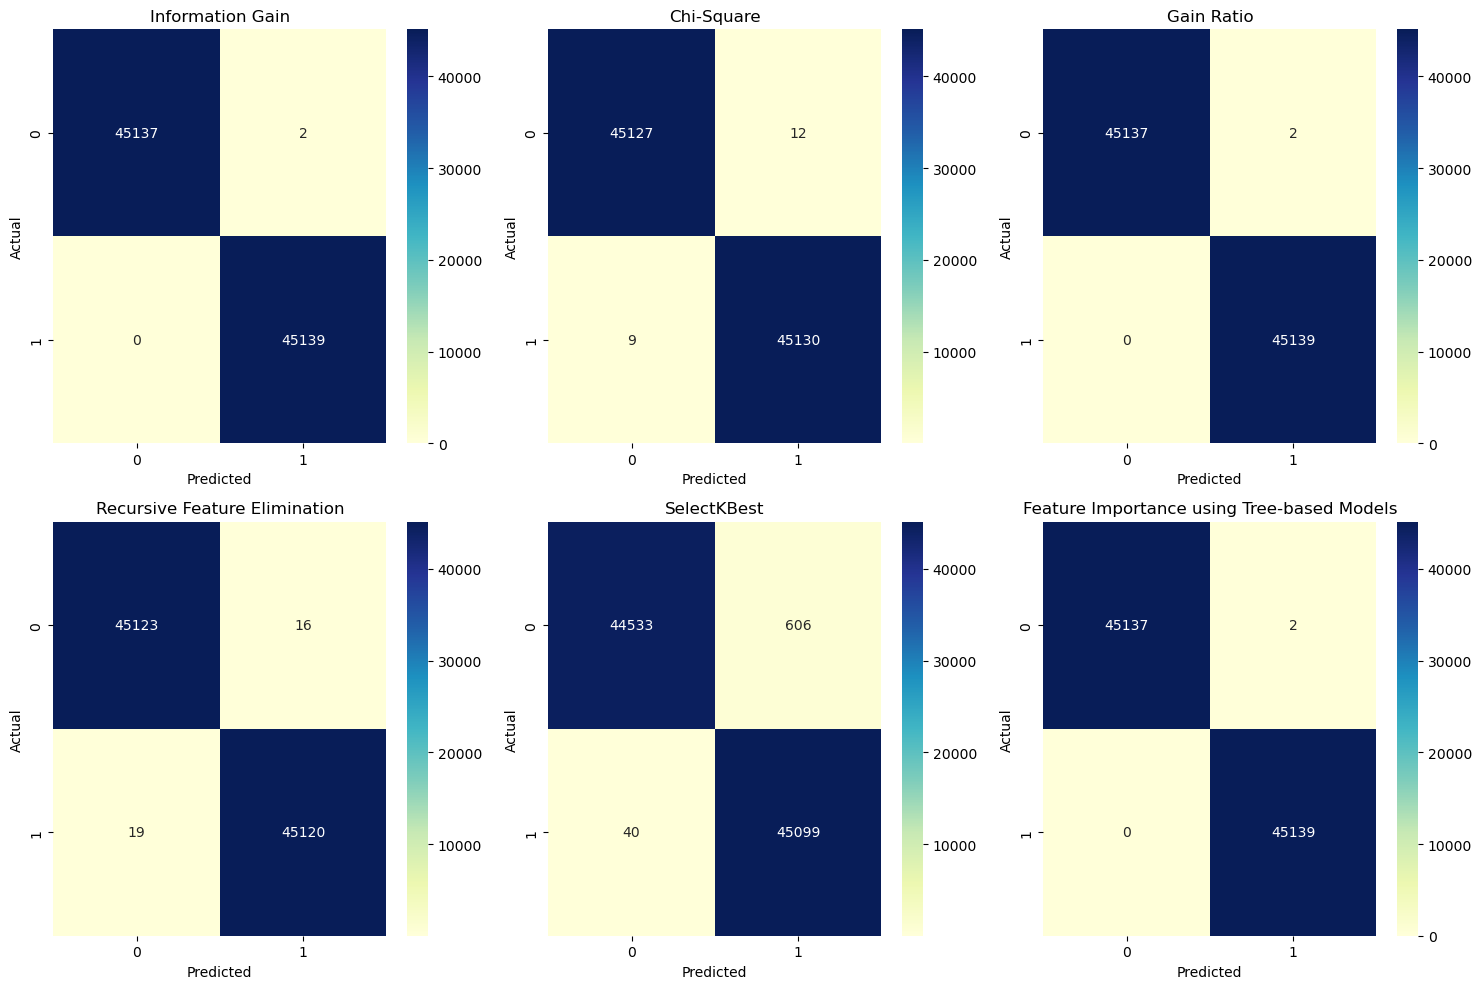

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define the models and their predictions
models = {
    "Information Gain": y_pred_ig,
    "Chi-Square": y_pred_cs,
    "Gain Ratio": y_pred_gr,
    "Recursive Feature Elimination": y_pred_rfe,
    "SelectKBest": y_pred_skb,
    "Feature Importance using Tree-based Models": y_pred_rf,
}

# Compute confusion matrices and plot heatmaps
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, (name, y_pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()


## Features selected by each technique

In [10]:
# Define the selected columns by each technique
selected_columns = {
    "Information Gain": selected_columns_ig,
    "Chi-Square": selected_columns_cs,
    "Gain Ratio": selected_columns_gr,
    "Recursive Feature Elimination": selected_columns_rfe,
    "SelectKBest": selected_columns_skb,
    "Feature Importance using Tree-based Models": selected_columns_rf,
}

# Print the selected features
for name, columns in selected_columns.items():
    print(f"{name}:")
    for column in columns:
        print(f"  - {column}")
    print()


Information Gain:
  - Dst Port
  - Flow Duration
  - Flow IAT Mean
  - Flow IAT Max
  - Fwd IAT Tot
  - Fwd IAT Mean
  - Fwd IAT Max
  - Fwd IAT Min
  - Fwd Pkts/s
  - Date

Chi-Square:
  - Flow Duration
  - Bwd Pkt Len Max
  - Fwd IAT Tot
  - Bwd IAT Tot
  - Pkt Len Max
  - RST Flag Cnt
  - ACK Flag Cnt
  - ECE Flag Cnt
  - Init Bwd Win Byts
  - Date

Gain Ratio:
  - Dst Port
  - Flow Duration
  - Flow IAT Mean
  - Flow IAT Max
  - Fwd IAT Tot
  - Fwd IAT Mean
  - Fwd IAT Max
  - Fwd IAT Min
  - Fwd Pkts/s
  - Date

Recursive Feature Elimination:
  - Flow IAT Min
  - Fwd Header Len
  - Fwd Pkts/s
  - Bwd Pkts/s
  - Pkt Len Max
  - Pkt Len Var
  - Bwd Seg Size Avg
  - Subflow Bwd Byts
  - Init Fwd Win Byts
  - Init Bwd Win Byts

SelectKBest:
  - Protocol
  - Bwd Pkt Len Max
  - Bwd Pkt Len Min
  - Bwd Pkt Len Mean
  - Bwd Pkt Len Std
  - Pkt Len Min
  - Pkt Len Mean
  - Pkt Size Avg
  - Bwd Seg Size Avg
  - Date

Feature Importance using Tree-based Models:
  - Dst Port
  - Bwd Pkt Len 

## Final selected features

In [12]:
# Find the union of the two sets of selected features
combined_features = set(selected_columns_ig).union(selected_columns_rf).union(selected_columns_gr)

# Print the combined features
print("Combined Features (Information Gain, Gain Ratio & Feature Importance using Tree-based Models):")
for feature in combined_features:
    print(f"  - {feature}")

Combined Features (Information Gain, Gain Ratio & Feature Importance using Tree-based Models):
  - Bwd Seg Size Avg
  - Flow IAT Mean
  - Fwd IAT Tot
  - Fwd IAT Max
  - Flow IAT Max
  - Flow Duration
  - Dst Port
  - Fwd IAT Min
  - Fwd Pkts/s
  - Date
  - Fwd IAT Mean
  - Bwd Pkt Len Mean
